In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os
import shutil
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D,\
    Dense, Layer, Reshape, InputLayer, Flatten, Input, MaxPooling2D
from alibi_detect.od import OutlierAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [10]:
def img_to_np(path, resize = True):  
    img_array = []
    fpaths = glob.glob(path)
    for fname in fpaths:
        img = Image.open(fname).convert("RGB")
        if(resize): img = img.resize((64,64))
        img_array.append(np.asarray(img))
    images = np.array(img_array)
    return images

path = "D:\\cybord\\img\\comp4\\*.*"
train = img_to_np(path)
train = train.astype('float32') / 255.
#test = test.astype('float32') / 255.

print(train.shape)

(1007, 64, 64, 3)


In [11]:
encoding_dim = 1024

dense_dim = [8, 8, 128]

encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])


# initialize outlier detector
od = OutlierAE( threshold = 0.001,
                encoder_net=encoder_net,
                decoder_net=decoder_net)

adam = tf.keras.optimizers.Adam(lr=1e-4)

#train
od.fit(train, epochs=100, verbose=True,
       optimizer = adam)

decoder_net.summary()

16/16 [=] - 1s 48ms/step - loss: 4.7337e-04
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 8192)              8396800   
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 16, 16, 256)       524544    
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 32, 32, 64)        262208    
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 64, 64, 3)         3075      
Total params: 9,186,627
Trainable params: 9,186,627
Non-trainable params: 0
_________________________________________________________________


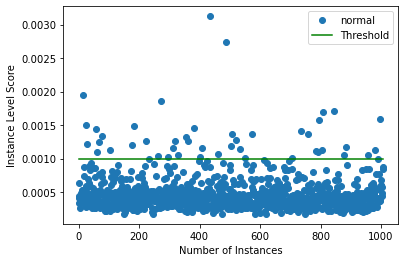

Counter({0: 962, 1: 45})

In [12]:
preds = od.predict(train, outlier_type='instance',
            return_instance_score=True,
            return_feature_score=True)

target = np.zeros(train.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(preds, target, labels, od.threshold)

Counter(preds['data']['is_outlier'])

<Figure size 864x576 with 0 Axes>

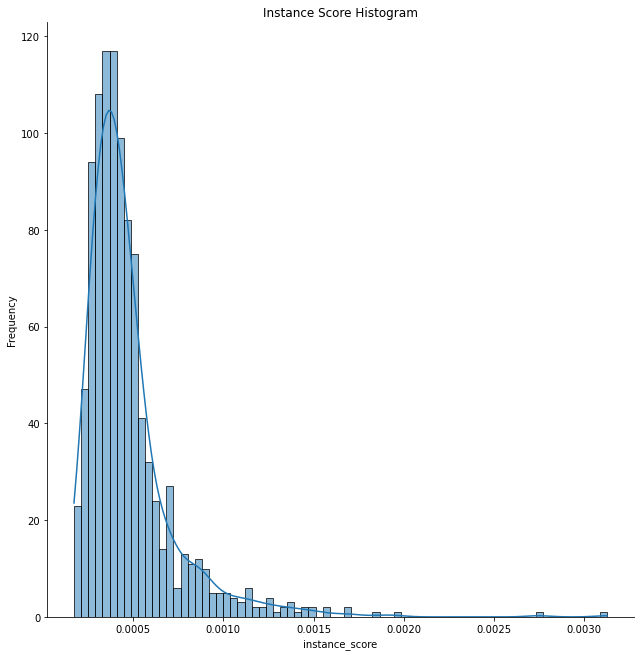

threshold: 0.001


In [13]:
import seaborn as sns

plt.figure(figsize=(12,8))
sns.displot(data=preds['data'], x='instance_score', kde=True, height=9)
plt.title('Instance Score Histogram')
plt.ylabel('Frequency')
plt.show()

thresh = od.threshold
print("threshold:", thresh)

In [14]:
print('99th percentile:', np.percentile(preds['data']['instance_score'], 90))

99th percentile: 0.0007521324674598869


In [15]:
fpaths = glob.glob('img/*.*')

for fname in fpaths:
    os.remove(fname)

for i, fpath in enumerate(glob.glob(path)):
    if(preds['data']['is_outlier'][i] == 1):
        source = fpath
        shutil.copy(source, 'img/')

FileNotFoundError: [Errno 2] No such file or directory: 'img/[X0603_2]_[CAP]_[141]_[MLCAP000236]_[HK_150100-A]_[1022(0603 Capacitor)]_[System-Line-M-Sipl1_D4_M]_[03082020]_[1.6]_[0.8]_[Regular_1022(0603 Capacitor)_Sensor1030_Q915]_[202611.4301]_[2.92x1.39]_comp.jpg'

In [16]:
filenames = [os.path.basename(x) for x in glob.glob(path)]

dict1 = {'Filename': filenames,
     'instance_score': preds['data']['instance_score'],
     'is_outlier': preds['data']['is_outlier']}
     
df = pd.DataFrame(dict1)

df[df['is_outlier'] == 1]

,Filename,instance_score,is_outlier
14,[X0603_2]_[CAP]_[141]_[MLCAP000236]_[HK_150100...,0.001951,1
26,[X0603_2]_[CAP]_[141]_[MLCAP000236]_[HK_150100...,0.001502,1
29,[X0603_2]_[CAP]_[141]_[MLCAP000236]_[HK_150100...,0.001221,1
58,[X0603_2]_[CAP]_[141]_[MLCAP000236]_[HK_150100...,0.001447,1
62,[X0603_2]_[CAP]_[141]_[MLCAP000236]_[HK_150100...,0.001100,1
68,[X0603_2]_[CAP]_[141]_[MLCAP000236]_[HK_150100...,0.001242,1
77,[X0603_2]_[CAP]_[141]_[MLCAP000236]_[HK_150100...,0.001337,1
105,[X0603_2]_[CAP]_[141]_[MLCAP000236]_[HK_150100...,0.001131,1
176,[X0603_2]_[CAP]_[141]_[MLCAP000236]_[HK_150100...,0.001206,1
184,[X0603_2]_[CAP]_[141]_[MLCAP000236]_[HK_150100...,0.001484,1


In [ ]:
recon = od.ae(train).numpy()

plot_feature_outlier_image(preds, train, 
                           X_recon=recon,  
                           max_instances=5,
                           outliers_only=True,
                           figsize=(20,20))